In [1]:
import random,os,csv,glob,math,logging
import json
import numpy as np
import pandas as pd
import time

import cv2 as cv
from sklearn.manifold import TSNE
import scipy.io as sio
from os.path import dirname, join as pjoin
import scipy.io as sio

from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate,LeakyReLU,Input, Dropout,Lambda,Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalAveragePooling1D,multiply
from tensorflow.keras.layers import Conv3D, MaxPooling3D

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  
from tensorflow.keras.callbacks import TensorBoard  
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
import sys

mod = sys.modules[__name__]
scaler = MinMaxScaler()

In [58]:
print(tf.__version__)

2.2.0


In [2]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in tqdm(range(X.shape[0])):
        # plot colored number
        if d[i] == 0:
            color = 'green'
        elif d[i] == 1:
            color = 'purple'
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
def voxel_load1(path,names):
    vox_list=[]
    for i in tqdm.tqdm(range(len(names))):
        vox = np.load(path+names[i]+'.npz')
        voxel = vox['x']
        if voxel.shape[0] == 32:
            voxel[:,:,:10]=0
        else:
            voxel[:,:,:20]=0
        vox_list.append(voxel)
    vox_list = np.asarray(vox_list)
    vox_sp = vox_list.shape
    vox_list = vox_list.reshape(vox_sp[0],vox_sp[1],vox_sp[2],vox_sp[3],1)
    print(np.shape(vox_list))
    return vox_list

def voxel_load2(path,names):
    vox_list=[]
    for i in tqdm.tqdm(range(len(names))):
        mat_contents = sio.loadmat(path+names[i]+'.mat')
        voxel = mat_contents['Volume1']
        if voxel.shape[0] == 32:
            voxel[:,:,:10]=0
        else:
            voxel[:,:,:20]=0
        vox_list.append(voxel)
        
    vox_list = np.asarray(vox_list)
    vox_sp = vox_list.shape
    vox_list = vox_list.reshape(vox_sp[0],vox_sp[1],vox_sp[2],vox_sp[3],1)
    print(np.shape(vox_list))
    return vox_list

def df_load(df_path,df_type):
    df = pd.read_csv(df_path)
    data = df[df_type]
    data = np.asarray(data)
    print(df_type,data.shape)
    return data


In [4]:
src = './WHEEL_data/'

In [5]:
df_concept = pd.read_csv(src+'LABEL/concept/concept_label.csv')
df_detailed = pd.read_csv(src+'LABEL/chassis/chassis_label.csv')

In [6]:
concept_names = df_concept['name']
concept_stiff = np.array(df_concept['stiffness(n/m)'])

detailed_names = df_detailed['name']
detailed_stiff = np.array(df_detailed['stiffness(n/m)'])

In [7]:
stiff = np.concatenate([concept_stiff,detailed_stiff])

In [8]:
scaler = MinMaxScaler()
scaler.fit(stiff.reshape(-1,1))
concept_stiff_sc = scaler.transform(concept_stiff.reshape((-1, 1)))
detailed_stiff_sc = scaler.transform(detailed_stiff.reshape(-1, 1))

(array([ 1.,  2.,  7.,  8.,  9., 13.,  9.,  7.,  7.,  2.]),
 array([2.05818745e+08, 2.29551030e+08, 2.53283314e+08, 2.77015599e+08,
        3.00747884e+08, 3.24480169e+08, 3.48212454e+08, 3.71944739e+08,
        3.95677024e+08, 4.19409308e+08, 4.43141593e+08]),
 <BarContainer object of 10 artists>)

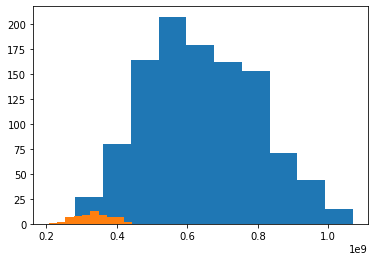

In [9]:
plt.hist(concept_stiff)
plt.hist(detailed_stiff)

In [10]:
src2 = src+'INPUT/'
vox64_concept  = voxel_load1(src2+'concept/Voxel_64/',concept_names)
vox64_detailed = voxel_load2(src2+'chassis/voxel_64/',detailed_names)
vox32_concept  = voxel_load1(src2+'concept/Voxel_32/',concept_names)
vox32_detailed = voxel_load2(src2+'chassis/voxel_32/',detailed_names)

 22%|██▏       | 239/1102 [00:00<00:00, 2382.11it/s]

(1102, 64, 64, 64, 1)
(65, 64, 64, 64, 1)


100%|██████████| 65/65 [00:00<00:00, 4312.06it/s]

(1102, 32, 32, 32, 1)
(65, 32, 32, 32, 1)


In [22]:
vox_grid = 32
trainX = getattr(mod,'vox{}_concept'.format(vox_grid))[:990]
trainY = concept_stiff_sc[:990]
testX = getattr(mod,'vox{}_concept'.format(vox_grid))[990:]
testY = concept_stiff_sc[990:]

trainDX = getattr(mod,'vox{}_detailed'.format(vox_grid))[:50]
trainDY = detailed_stiff_sc[:50]
testDX = getattr(mod,'vox{}_detailed'.format(vox_grid))[50:]
testDY = detailed_stiff_sc[50:]

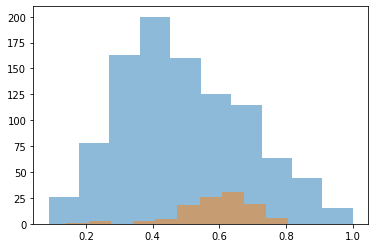

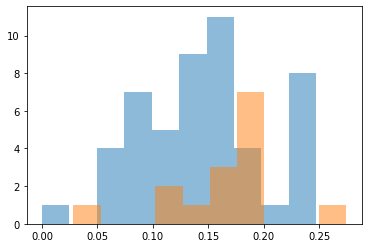

In [23]:
plt.hist(trainY,alpha = 0.5)
plt.hist(testY,alpha = 0.5)
plt.show()

plt.hist(trainDY,alpha = 0.5)
plt.hist(testDY,alpha = 0.5)
plt.show()

In [24]:
combined_train_imgs = np.concatenate([trainX, trainDX])
combined_train_labels = np.concatenate([trainY, trainDY])
combined_train_domain = np.concatenate([np.tile([1., 0.], [len(trainX), 1]),
                                        np.tile([0., 1.], [len(trainDX), 1])])
print(combined_train_imgs.shape,combined_train_labels.shape,combined_train_domain.shape)

(1040, 32, 32, 32, 1) (1040, 1) (1040, 2)


In [25]:
combined_test_imgs = np.concatenate([testX, testDX])
combined_test_labels = np.concatenate([testY, testDY])
combined_test_domain = np.concatenate([np.tile([1., 0.], [len(testX), 1]),
                                        np.tile([0., 1.], [len(testDX), 1])])

print(combined_test_imgs.shape,combined_test_labels.shape,combined_test_domain.shape)

(127, 32, 32, 32, 1) (127, 1) (127, 2)


In [26]:
def BLOCK(input_a,c):
    added = Dense(c,
                  use_bias=True, 
                  kernel_initializer='glorot_normal',
                  bias_initializer='zeros', kernel_regularizer=None)(input_a)
    added = BatchNormalization()(added)
    return LeakyReLU(alpha=0.1)(added)
def feature_extractor(inp):
    x1 = Conv3D(16,(3,3,3),use_bias=True, kernel_initializer='glorot_normal', 
                  bias_initializer='zeros', kernel_regularizer=None,name='conv1')(inp)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = Conv3D(16,(3,3,3),use_bias=True, kernel_initializer='glorot_normal', 
                  bias_initializer='zeros', kernel_regularizer=None,name='conv2')(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = MaxPooling3D((2,2,2),name='maxpooling1')(x1)
    x1 = Dropout(rate=0.3)(x1)
    x1 = Conv3D(32,(3,3,3),use_bias=True, kernel_initializer='glorot_normal', 
                  bias_initializer='zeros', kernel_regularizer=None,name='conv3')(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = Conv3D(32,(3,3,3),use_bias=True, kernel_initializer='glorot_normal', 
                  bias_initializer='zeros', kernel_regularizer=None,name='conv4')(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = MaxPooling3D((2,2,2),name='maxpooling2')(x1)
    x1 = Dropout(rate=0.3)(x1)
    x1 = Conv3D(64,(3,3,3),use_bias=True, kernel_initializer='glorot_normal', 
                  bias_initializer='zeros', kernel_regularizer=None,name='conv5')(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = Flatten()(x1)
    return x1

def regressor(inp):
    added = BLOCK(inp,2000)
    added = BLOCK(added,300)
    added = BLOCK(added,150)
    added = BLOCK(added,20)
    added = BLOCK(added,16)
    out = Dense(1,name='regressor_output')(added)
    return out
def discriminator(inp):
    out = Dense(100, activation="relu")(inp)
    discriminator_output = Dense(2, activation="softmax", name="discriminator_output")(out)
    return discriminator_output
    
def cnn():
    inp =  Input(shape=(vox_grid,vox_grid,vox_grid,1))
    feature_output = feature_extractor(inp)
    regressor_output = regressor(feature_output)
    model = Model(inputs=inp, outputs=regressor_output)
    return model

@tf.custom_gradient
def GradientReversalOperator(x):
	def grad(dy):
		return -1 * dy
	return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
	def __init__(self):
		super(GradientReversalLayer, self).__init__()
		
	def call(self, inputs):
		return GradientReversalOperator(inputs)
  
def dann():
    inp =  Input(shape=(vox_grid,vox_grid,vox_grid,1))
    feature_output = feature_extractor(inp)
    regressor_output = regressor(feature_output)

    grl_layer = GradientReversalLayer()(feature_output)
    discriminator_output = discriminator(grl_layer)
    model = tf.keras.models.Model(inputs=inp, outputs=[discriminator_output,regressor_output])
    return model

In [27]:
def mape(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true))*100
    
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape2(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
    
def rmse2(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def R2(y_true,y_pred):
    SSE = np.mean(np.square(y_true - y_pred))
    SSR = np.mean(np.square(y_true - np.var(y_true)))
    result = 1 - (SSE/SSR)
    return result

model_dir = './model_checkpoint/'
def mkdir(model_dir):
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

In [28]:
def training(model,model_name,dataset,loss):
  #hyperparameters
  lr= 0.0001
  bata_1= 0.9
  batch_size= 32
  epochs= 1000
  patience = 500
  loss = loss
  savename =  model_dir+model_name+".h5"

  if 'dann' in model_name:
    cp_callback = ModelCheckpoint(filepath = savename
                                  ,monitor='val_regressor_output_loss'
                                  ,save_best_only=True
                                  ,save_weights_only=True)

    early_stopping = EarlyStopping(monitor='val_regressor_output_loss'
                                  ,patience=patience)
    model.compile(optimizer=Adam(lr=lr)
                  ,loss={'regressor_output': loss
                         ,'discriminator_output': 'binary_crossentropy'})
  else:
    cp_callback = ModelCheckpoint(filepath = savename
                                ,monitor='val_loss'
                                ,save_best_only=True
                                ,save_weights_only=False)

    early_stopping = EarlyStopping(monitor='val_loss'
                                ,patience=patience)
    model.compile(loss=loss,optimizer=Adam(lr=lr))
  
  startTime = time.time()

  #x_train,y_train = combined_train_imgs,combined_train_labels
  x_train,y_train,x_valid,y_valid = dataset
  #x_valid,y_valid = combined_test_imgs,combined_test_labels

  hist = model.fit(x_train,y_train
                  ,batch_size=batch_size
                  ,epochs= epochs
                  ,verbose= 1
                  ,validation_data =(x_valid,y_valid)
                  ,callbacks=[cp_callback, early_stopping])

  endTime = time.time() - startTime
  print("end time:",round(endTime,2))
  return model


In [ ]:
model_name = 'source_only_model_{}'.format(vox_grid)
mkdir(model_dir)
dataset = trainX,trainY,testX,testY
source_only_model = training(cnn(),
                             model_name,
                             dataset,
                             'mse')

In [ ]:
model_name = 'source_add_target_{}'.format(vox_grid)
mkdir(model_dir)
dataset = (combined_train_imgs,combined_train_labels
           ,combined_test_imgs,combined_test_labels)
source_add_target_model = training(cnn(),
                             model_name,
                             dataset,
                             'mse')

In [ ]:
model_name = 'dann_{}'.format(vox_grid)
dataset = (combined_train_imgs,[combined_train_domain,combined_train_labels]
          ,combined_test_imgs,[combined_test_domain,combined_test_labels])

dann_model = training(dann(),
                      model_name,
                      dataset,
                      'mse')

In [32]:
del source_only_model
del source_add_target_model
del dann_model

In [38]:
source_only_model = load_model('./model_checkpoint/source_only_model_{}.h5'.format(vox_grid))
source_add_target_model = load_model('./model_checkpoint/source_add_target_{}.h5'.format(vox_grid))

In [34]:
dann_model = dann()
dann_model.load_weights('./model_checkpoint/dann_{}.h5'.format(vox_grid))

In [44]:
def show_predict(model,input,label):
  pred = model.predict(input)
  if len(pred)==2:
    pred=pred[1]
  print("rmse:",round(rmse2(pred,label),4))
  y_pred =scaler.inverse_transform(pred)
  y_true =scaler.inverse_transform(label)
  print("mape:",round(mape2(y_true,y_pred),4))
  return y_true,y_pred

In [45]:
y_true,y_pred = show_predict(source_only_model,testX,testY)
y_true,y_pred = show_predict(source_only_model,testDX,testDY)

rmse: 0.0322
mape: 3.0186
rmse: 0.2578
mape: 62.6935


In [46]:
y_true,y_pred = show_predict(source_add_target_model,testX,testY)
y_true,y_pred = show_predict(source_add_target_model,testDX,testDY)

rmse: 0.0285
mape: 2.7875
rmse: 0.053
mape: 11.3794


In [56]:
y_true,y_pred = show_predict(dann_model,testX,testY)
y_true,y_pred = show_predict(dann_model,testDX,testDY)

rmse: 0.0316
mape: 3.0702
rmse: 0.0389
mape: 7.3612


In [52]:
def percent(value1, value2):
    result = 1-(value2/value1)
    print(round(result,4)*100,'%')

In [55]:
percent(0.0285,0.0316)
percent(2.7875,3.0702)
percent(0.053,0.0389)
percent(11.3794,7.3612)

-10.879999999999999 %
-10.14 %
26.6 %
35.31 %
